# **Practico Mentoria - Aprendizaje No Supervisado**
---

Se propone la elaboración de un informe o presentación, en formato estatico:
* PDF
* Markdowns
* Google Docs

Que responda a las cuestiones solicitadas en cada seccion de esta **Jupyter Notebook**.

La comunicación debe estar apuntada a un público técnico pero sin conocimiento del tema particular, como por ejemplo, sus compañeros de clase.  
Por lo cual debe estar redactado de forma consisa y comprensible.

## **Referencias**:
* https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3
* https://www.intechopen.com/online-first/clustering-of-time-series-data
* http://halweb.uc3m.es/esp/Personal/personas/amalonso/esp/ASDM-C02-clustering.pdf
* https://tslearn.readthedocs.io/en/stable/

## **Clustering to Time Series Data**

La idea de este practico es poder aplicar Tecnicas de Clustering sobre los diferentes `PUNTO_MEDICION` (que podemos considerar como Series Temporales independientes), con el fin de determinar diferentes agrupamientos en donde los `PUNTOS_MEDICION` sean similares, en algun sentido. 

Para ello pueden utilizar la libreria `tslearn`, la cual es una libreria de machine learning para el analisis de Series Temporales, construidas a partir de la las librerias `scikit-learn` y `numpy` entre otras.


## Resumen

En esta notebook proponemos un análisis al Dataset en su conjunto, teniendo como premisa la estandarización del tráfico que caracteriza a la feature *outbound* en Gigabits, es decir, no individualizamos equipos que operan en Megabits y Gigabits para no forzar el agrupamiento en diferentes Cluster.
Esto se desarrola las secciones de 1 a 4

En la segunda parte 
En esta notebook proponemos el análisis del Dataset teniendo en cuenta el agrupamiento de primera parte, pero analizando el cluster que mayor numero puntos de medicion agrupa, verificando los diferentes Cluster internos.


Y por último La ultima parte 

En la presente notebook seleccionaremos un equipo en particular para analizar la forma en que el modelo clusteriza o agrupa los puntos de medicion. Estandarizando el tráfico de salida (feaure *outbpound*) en Gigabits.

## 1 Inicialización del entorno
---

In [72]:
!pip install tslearn


In [73]:
import io
import datetime
import warnings
import requests

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

from sklearn.metrics import silhouette_samples

from sklearn.cluster import KMeans,MeanShift, DBSCAN,  estimate_bandwidth, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.neighbors import kneighbors_graph

In [74]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15, 5)})

In [75]:
filename = "https://raw.githubusercontent.com/diplodatos2020/Introduccion_Mentoria/master/dataset_inf_telec_20200501T130000_20200727T010000_v1.csv"

In [76]:
df = pd.read_csv(
    filename,
    dtype={
        'ID_EQUIPO': int,
        'PUNTO_MEDICION': str,
        'CAPACIDAD_MAXIMA_GBS': float,
        'PASO': int,
        'LATENCIA_MS': float,
        'PORCENTAJE_PACK_LOSS': float,
        'INBOUND_BITS': np.float64,
        'OUTBOUND_BITS': np.float64,
        'MEDIDA': str,
    },
    index_col='FECHA_HORA',
    parse_dates=[
        'FECHA_INICIO_MEDICION',
        'FECHA_HORA',
        'FECHA_FIN_MEDICION',
    ],
    na_values=['NaN']
)

print(df.shape)
display(df.head(10))

(61548, 11)


,ID_EQUIPO,PUNTO_MEDICION,CAPACIDAD_MAXIMA_GBS,FECHA_INICIO_MEDICION,FECHA_FIN_MEDICION,PASO,LATENCIA_MS,PORCENTAJE_PACK_LOSS,INBOUND_BITS,OUTBOUND_BITS,MEDIDA
FECHA_HORA,,,,,,,,,,,
2020-05-01 03:00:00,25,ABA - Abasto Cliente,1.0,2020-05-01 01:00:00.000,2020-05-28 13:00:00.000,7200,0.636025,0.0,2.574323e+06,5.511033e+06,MB
2020-05-01 05:00:00,25,ABA - Abasto Cliente,1.0,2020-05-01 01:00:00.000,2020-05-28 13:00:00.000,7200,0.604169,0.0,2.890153e+06,4.081183e+06,MB
2020-05-01 07:00:00,25,ABA - Abasto Cliente,1.0,2020-05-01 00:59:59.995,2020-05-28 12:59:59.995,7200,0.630580,0.0,2.152505e+06,4.904134e+06,MB
2020-05-01 09:00:00,25,ABA - Abasto Cliente,1.0,2020-05-01 00:59:59.995,2020-05-28 12:59:59.995,7200,0.643044,0.0,6.436357e+06,1.015017e+07,MB
2020-05-01 11:00:00,25,ABA - Abasto Cliente,1.0,2020-05-01 00:59:59.995,2020-05-28 12:59:59.995,7200,0.620542,0.0,3.173940e+06,4.403766e+06,MB
2020-05-01 13:00:00,25,ABA - Abasto Cliente,1.0,2020-05-01 00:59:59.995,2020-05-28 12:59:59.995,7200,0.611687,0.0,1.818024e+06,5.041605e+06,MB
2020-05-01 15:00:00,25,ABA - Abasto Cliente,1.0,2020-05-01 00:59:59.995,2020-05-28 12:59:59.995,7200,0.647121,0.0,2.269738e+06,3.317918e+06,MB
2020-05-01 17:00:00,25,ABA - Abasto Cliente,1.0,2020-05-01 00:59:59.995,2020-05-28 12:59:59.995,7200,0.613206,0.0,3.333695e+06,5.551954e+06,MB
2020-05-01 19:00:00,25,ABA - Abasto Cliente,1.0,2020-05-01 00:59:59.995,2020-05-28 12:59:59.995,7200,0.619800,0.0,4.434273e+06,7.047717e+06,MB


Limpieza del dataset



In [77]:
df_missing_values_count = df.isnull().sum()
df_missing_values_count[df_missing_values_count > 0]

LATENCIA_MS             48
PORCENTAJE_PACK_LOSS    49
INBOUND_BITS            47
OUTBOUND_BITS           47
dtype: int64

In [78]:
df_notnull = df[pd.notnull(df['PORCENTAJE_PACK_LOSS'])]
print('LATENCIA_MS ', df_notnull.LATENCIA_MS.isnull().sum())
print('PORCENTAJE_PACK_LOSS ', df_notnull.PORCENTAJE_PACK_LOSS.isnull().sum())
print('OUTBOUND_BITS ', df_notnull.OUTBOUND_BITS.isnull().sum())
print('INBOUND_BITS ', df_notnull.INBOUND_BITS.isnull().sum())

df_notnull.shape

LATENCIA_MS  0
PORCENTAJE_PACK_LOSS  0
OUTBOUND_BITS  0
INBOUND_BITS  0


(61499, 11)

pasamos a la unidad de medida Gb



In [79]:
df['INBOUND_BITS'] = df['INBOUND_BITS'] / 1e9
df['OUTBOUND_BITS'] = df['OUTBOUND_BITS'] / 1e9

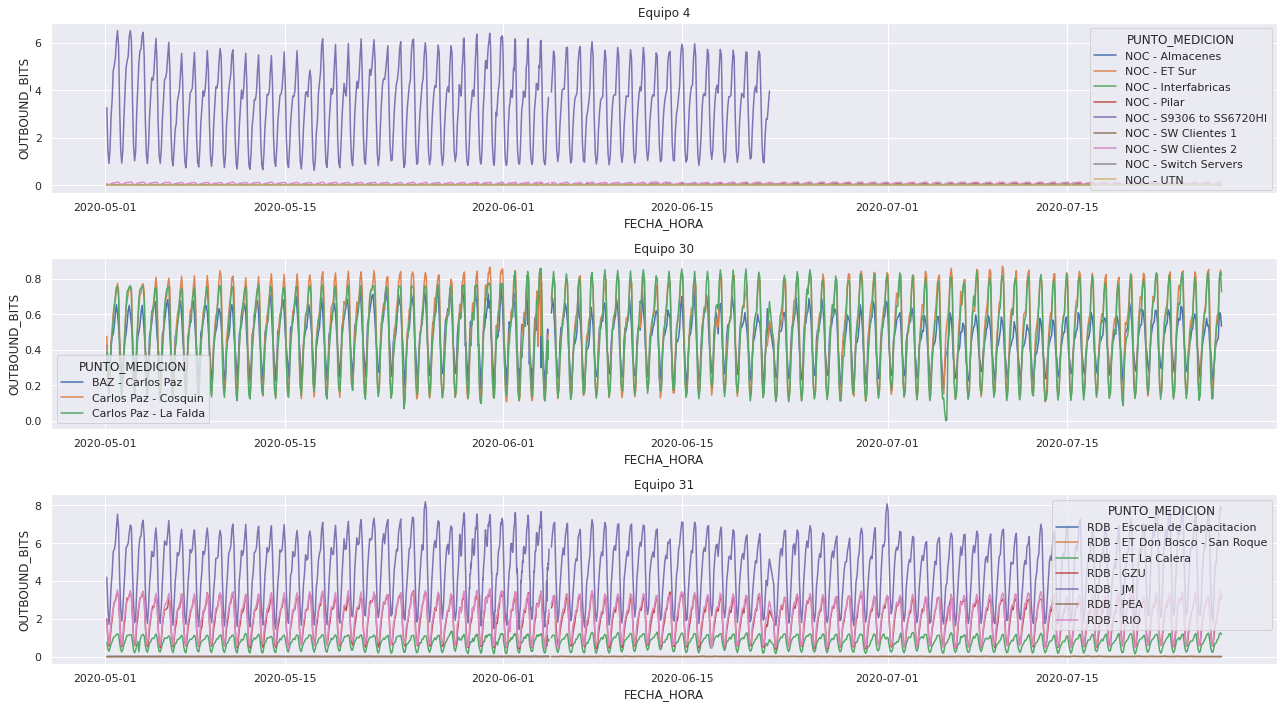

In [80]:
fig = plt.figure(figsize=(18, 10))
auxf = df

# Equipos 1, 4, 11, 23, 24, 25, 28, 30, 31, 41, 62
#ids = [1, 4, 11]
ids = [4, 30, 31]
#ids = [28, 30, 31]

idx = 0
for id in ids:
  idx += 1
  ax = plt.subplot(len(ids), 1, idx)
  sns.lineplot(x="FECHA_HORA", y="OUTBOUND_BITS", hue='PUNTO_MEDICION', 
               data=auxf[auxf.ID_EQUIPO == id], ax=ax)
  ax.set_title(f'Equipo {id}')
  # end for
plt.tight_layout()
plt.show()

In [81]:

meds = ['EDC - NOR','EDC - RDB', 'ABA - Temple']
df = df[~df.PUNTO_MEDICION.isin(meds)]

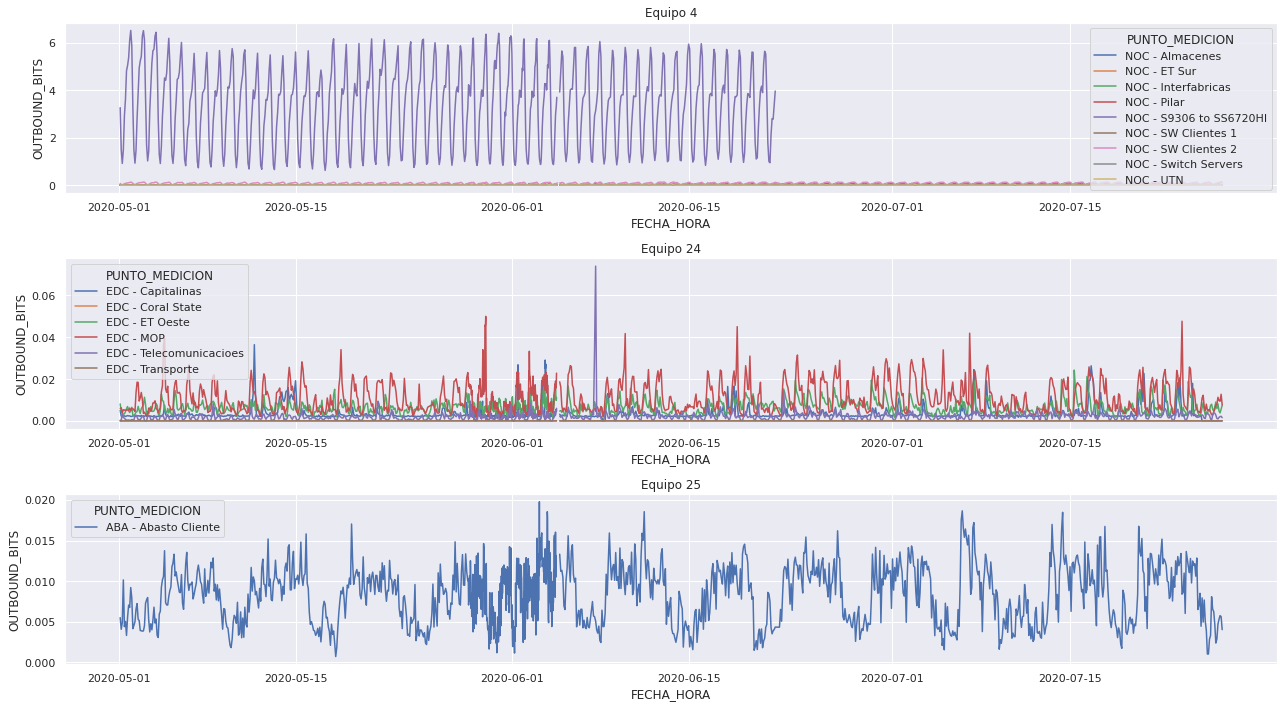

In [82]:
fig = plt.figure(figsize=(18, 10))
auxf = df
ids = [4, 24, 25]
idx = 0
for id in ids:
  idx += 1
  ax = plt.subplot(len(ids), 1, idx)
  sns.lineplot(x="FECHA_HORA", y="OUTBOUND_BITS", hue='PUNTO_MEDICION', 
               data=auxf[auxf.ID_EQUIPO == id], ax=ax)
  ax.set_title(f'Equipo {id}')
  # end for
plt.tight_layout()
plt.show()

##  Clustering K means
---



In [83]:
df_cluster = df

In [84]:
cols= ['PUNTO_MEDICION', 'OUTBOUND_BITS']

df_cluster = df_cluster[cols].pivot(
    columns='PUNTO_MEDICION', values=['OUTBOUND_BITS'])

df_cluster.columns = df_cluster.columns.droplevel()
df_cluster = df_cluster.dropna()

In [85]:
df_cluster.head(5)

PUNTO_MEDICION,ABA - Abasto Cliente,BAZ - Carlos Paz,BAZ - Yocsina,Carlos Paz - Cosquin,Carlos Paz - La Falda,EDC - Capitalinas,EDC - Coral State,EDC - ET Oeste,EDC - MOP,EDC - Telecomunicacioes,EDC - Transporte,JM - Totoral Nueva,JM - Totoral Vieja,NOC - 6720HI to BAZ,NOC - 6720HI to EDC,NOC - 6720HI to ETC,NOC - 6720HI to N20-1,NOC - 6720HI to R4 Silica,NOC - 6720HI to RPrivado,NOC - ACHALA - Servicios,NOC - ACHALA - Solo Dolores,NOC - Almacenes,NOC - ET Sur,NOC - Interfabricas,NOC - Pilar,NOC - S9306 to SS6720HI,NOC - SW Clientes 1,NOC - SW Clientes 2,NOC - Switch Servers,NOC - UTN,RDB - ET Don Bosco - San Roque,RDB - ET La Calera,RDB - Escuela de Capacitacion,RDB - GZU,RDB - JM,RDB - PEA,RDB - RIO,SF - Freyre,SF - La Francia,SF - Las Varillas,SF - SF Adm,SF - SF Cliente,Yocsina - Alta Gracia,Yocsina - Carlos Paz,Yocsina - Mogote
FECHA_HORA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-01 03:00:00,0.005511,0.426356,0.665112,0.476195,0.385283,0.005022,0.000006,0.008120,0.005954,0.000254,0.000006,0.000031,1.150525,8.868724,12.810691,0.122938,1.537623,0.294570,0.001455,0.002270,0.070785,0.011492,0.007417,0.003231,0.005406,3.263484,0.002892,0.076166,0.000196,0.000642,0.000381,0.746422,0.001458,1.981707,4.203994,0.000473,1.883304,1.108333,0.182251,0.040264,0.000836,0.001163,0.631768,2.759864,0.313744
2020-05-01 05:00:00,0.004081,0.346083,0.582230,0.245295,0.202661,0.002310,0.000006,0.004459,0.006254,0.000111,0.000006,0.000031,0.665254,4.648738,6.897302,0.075870,1.240372,0.136459,0.001422,0.001479,0.024550,0.007324,0.007963,0.003274,0.004098,1.498282,0.002213,0.028397,0.000236,0.000318,0.000370,0.397340,0.001133,0.891574,2.607257,0.000798,0.999204,0.541653,0.150965,0.017782,0.000115,0.001014,0.309540,1.330793,0.268583
2020-05-01 07:00:00,0.004904,0.226594,0.463523,0.159789,0.152798,0.002392,0.000006,0.003795,0.003946,0.003428,0.000006,0.000031,0.513287,3.155891,4.698255,0.032474,0.880236,0.073036,0.001413,0.000803,0.017070,0.002766,0.007027,0.003556,0.002862,0.916145,0.002121,0.021716,0.000146,0.000638,0.000276,0.280212,0.002212,0.557239,1.710703,0.000503,0.660877,0.410341,0.089833,0.012910,0.000112,0.002570,0.217094,0.810052,0.257046
2020-05-01 09:00:00,0.010150,0.264190,0.483912,0.260640,0.284799,0.002358,0.000006,0.003211,0.005318,0.001665,0.000006,0.000031,0.687094,4.757659,7.190201,0.034464,0.969063,0.136030,0.001421,0.001619,0.029991,0.003549,0.012249,0.003765,0.007309,1.486361,0.001782,0.034315,0.000152,0.000268,0.000633,0.442740,0.001360,0.843261,2.429658,0.000299,1.122275,0.686996,0.098816,0.027560,0.000116,0.003120,0.325725,1.305008,0.294852
2020-05-01 11:00:00,0.004404,0.418623,0.623917,0.449661,0.426247,0.002425,0.000006,0.003363,0.005255,0.001277,0.000006,0.000031,1.024443,8.061080,11.765868,0.047145,1.415550,0.261577,0.001425,0.001783,0.056098,0.005881,0.013362,0.004970,0.007735,2.906490,0.002769,0.060973,0.000154,0.001347,0.000311,0.692651,0.000608,1.539816,3.711353,0.000496,1.878020,1.180178,0.158308,0.054058,0.000199,0.006062,0.521417,2.429814,0.346706


In [86]:
df_cluster.shape

(866, 45)

In [87]:
df_cluster.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
PUNTO_MEDICION,,,,,,,,
ABA - Abasto Cliente,866.0,0.008225,3.408466e-03,0.000723,0.005344,0.008414,0.010635,0.019763
BAZ - Carlos Paz,866.0,0.484580,1.467481e-01,0.162448,0.361119,0.509480,0.603226,0.775242
BAZ - Yocsina,866.0,0.525491,1.018625e-01,0.328934,0.447891,0.532516,0.596445,0.920915
Carlos Paz - Cosquin,866.0,0.512570,2.275021e-01,0.075815,0.295038,0.540674,0.712717,0.864976
Carlos Paz - La Falda,866.0,0.491439,2.233504e-01,0.069303,0.281015,0.513161,0.690780,0.858993
EDC - Capitalinas,866.0,0.003449,3.353494e-03,0.000084,0.002204,0.002484,0.003049,0.036402
EDC - Coral State,866.0,0.000007,2.250392e-06,0.000005,0.000005,0.000007,0.000009,0.000014
EDC - ET Oeste,866.0,0.006263,2.755058e-03,0.000858,0.004224,0.005933,0.007925,0.017122
EDC - MOP,866.0,0.010279,6.970236e-03,0.001722,0.005047,0.007658,0.014176,0.049942


In [88]:
print(df_cluster.columns.values)

['ABA - Abasto Cliente' 'BAZ - Carlos Paz' 'BAZ - Yocsina'
 'Carlos Paz - Cosquin' 'Carlos Paz - La Falda' 'EDC - Capitalinas'
 'EDC - Coral State' 'EDC - ET Oeste' 'EDC - MOP'
 'EDC - Telecomunicacioes' 'EDC - Transporte' 'JM - Totoral Nueva'
 'JM - Totoral Vieja' 'NOC - 6720HI to BAZ' 'NOC - 6720HI to EDC'
 'NOC - 6720HI to ETC' 'NOC - 6720HI to N20-1' 'NOC - 6720HI to R4 Silica'
 'NOC - 6720HI to RPrivado' 'NOC - ACHALA - Servicios'
 'NOC - ACHALA - Solo Dolores' 'NOC - Almacenes' 'NOC - ET Sur'
 'NOC - Interfabricas' 'NOC - Pilar' 'NOC - S9306 to SS6720HI'
 'NOC - SW Clientes 1' 'NOC - SW Clientes 2' 'NOC - Switch Servers'
 'NOC - UTN' 'RDB - ET Don Bosco - San Roque' 'RDB - ET La Calera'
 'RDB - Escuela de Capacitacion' 'RDB - GZU' 'RDB - JM' 'RDB - PEA'
 'RDB - RIO' 'SF - Freyre' 'SF - La Francia' 'SF - Las Varillas'
 'SF - SF Adm' 'SF - SF Cliente' 'Yocsina - Alta Gracia'
 'Yocsina - Carlos Paz' 'Yocsina - Mogote']


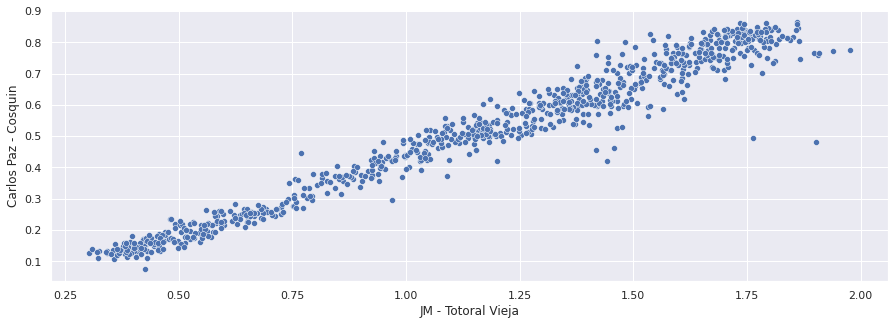

In [89]:
x = df_cluster['JM - Totoral Vieja']
y = df_cluster['Carlos Paz - Cosquin']
sns.scatterplot(data=df_cluster, x=x, y=y)

Matriz Traspuesta

In [90]:
x_traspuesta = df_cluster.values.T 
x_traspuesta.shape

(45, 866)




Observar la inercia en funcion del numero de clusters

In [91]:
normalize = Normalizer()
scaler = StandardScaler()
minmax = MinMaxScaler()

df_scaler = scaler.fit_transform(df_cluster)
df_norm = normalize.fit_transform(df_cluster)
df_minmax = minmax.fit_transform(df_cluster)

In [92]:
scores = [KMeans(n_clusters=i+2).fit(df_cluster).inertia_ for i in range(10)]
scores1 = [KMeans(n_clusters=i+2).fit(df_scaler).inertia_ for i in range(10)]
scores2= [KMeans(n_clusters=i+2).fit(df_norm).inertia_ for i in range(10)]
scores3 = [KMeans(n_clusters=i+2).fit(df_minmax).inertia_ for i in range(10)]

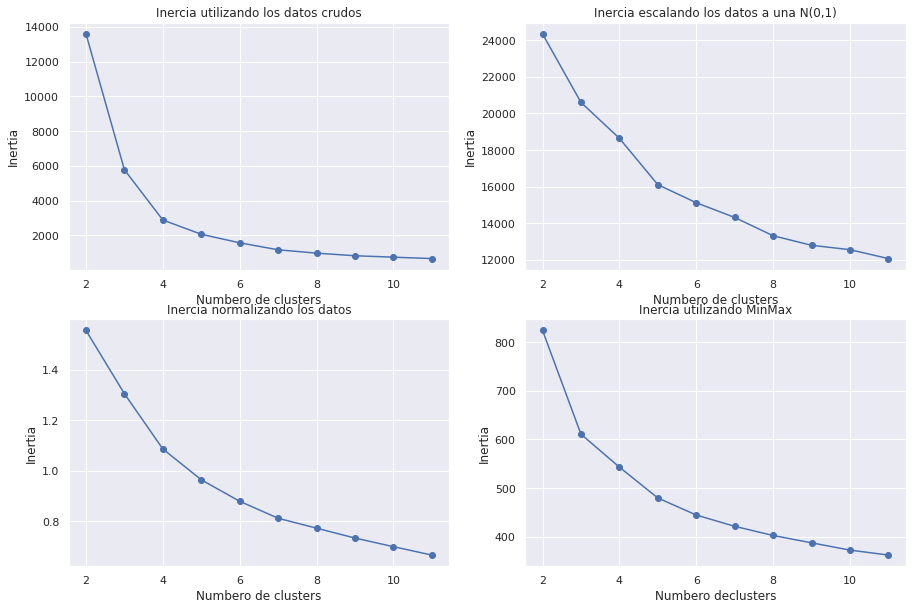

In [93]:

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(np.arange(2, 12), scores,marker='o')
plt.xlabel('Numbero de clusters')
plt.ylabel("Inertia")
plt.title("Inercia utilizando los datos crudos")
plt.subplot(2,2,2)
plt.plot(np.arange(2, 12), scores1,marker='o')
plt.xlabel('Numbero de clusters')
plt.ylabel("Inertia")
plt.title("Inercia escalando los datos a una N(0,1)")
plt.subplot(2,2,3)
plt.plot(np.arange(2, 12), scores2,marker='o')
plt.xlabel('Numbero de clusters')
plt.ylabel("Inertia")
plt.title("Inercia normalizando los datos")
plt.subplot(2,2,4)
plt.plot(np.arange(2, 12), scores3,marker='o')
plt.xlabel('Numbero declusters')
plt.ylabel("Inertia")
plt.title("Inercia utilizando MinMax")
plt.show()

In [94]:
#KMEANS
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(df_cluster)

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster / Inertia: ', km.inertia_)

Suma de los cuadrados de las distancias al cluster / Inertia:  2876.7033814275674


In [95]:
#MEANSHIFT
#bandwidth = estimate_bandwidth(df_cluster, quantile=0.048, n_samples=500)

ms = MeanShift( bin_seeding = True)

ms.fit(df_cluster)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero estimado de clusters para MeanShift : %d" % n_clusters_)

Numero estimado de clusters para MeanShift : 2


In [96]:
dbscan = DBSCAN(eps=0.001)
dbscan.fit(df_cluster)
cluster3 = dbscan.labels_

labels_unique = np.unique(cluster3)
n_clusters_ = len(labels_unique)

print("Numero estimado de clusters para DBSCAN : %d" % n_clusters_)

Numero estimado de clusters para DBSCAN : 1


In [97]:
n_clusters = 4

A = kneighbors_graph(df_cluster, 2, mode='connectivity', include_self=True)

ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='average', connectivity=A, affinity='cosine')
ward.fit(df_cluster)
cluster4 = ward.labels_
labels_unique = np.unique(cluster4)
n_clusters_ = len(labels_unique)
print("Numero estimado de clusters para average : %d" % n_clusters_)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_agglomerative.py:478: UserWarning: the number of connected components of the connectivity matrix is 228 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


Numero estimado de clusters para average : 4


In [98]:
gmm = GaussianMixture(n_components=4, covariance_type='full')
gmm.fit(df_cluster)
pred = gmm.predict(df_cluster)

In [99]:
km = KMeans(n_clusters)
km.fit(df_cluster)
pred = km.predict(df_cluster)

Text(0.5, 1.0, 'time agrupados por cluster WARD')

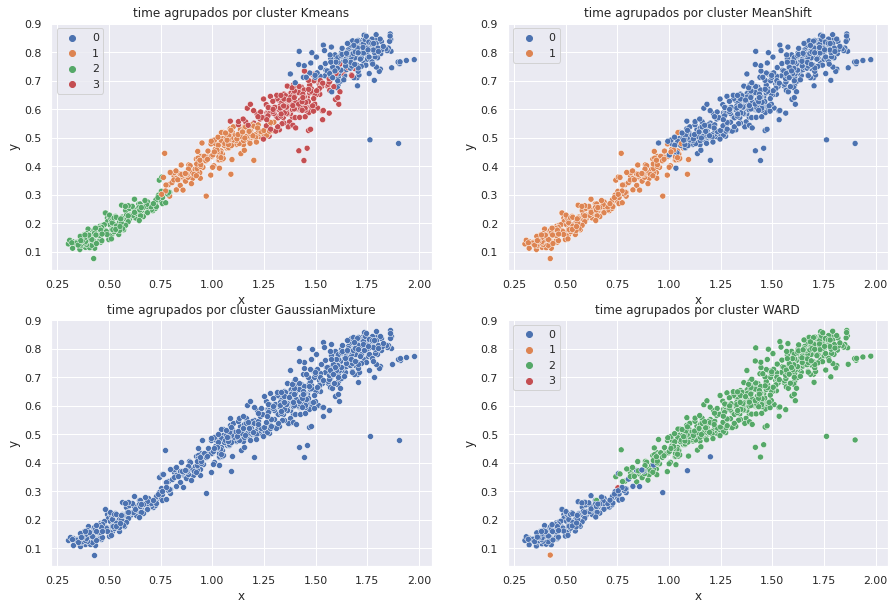

In [100]:

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.scatterplot(data=df_cluster, x=x, y=y, hue=clusters, palette="deep")
plt.xlabel('x')
plt.ylabel('y')
plt.title("time agrupados por cluster Kmeans")
plt.subplot(2,2,2)
sns.scatterplot(data=df_cluster, x=x, y=y, hue=clusters2, palette="deep")
plt.xlabel('x')
plt.ylabel('y')
plt.title("time agrupados por cluster MeanShift")
plt.subplot(2,2,3)
sns.scatterplot(data=df_cluster, x=x, y=y, palette="deep")
plt.xlabel('x')
plt.ylabel('y')
plt.title("time agrupados por cluster GaussianMixture")
plt.subplot(2,2,4)
sns.scatterplot(data=df_cluster, x=x, y=y, hue=cluster4, palette="deep")
plt.xlabel('x')
plt.ylabel('y')
plt.title("time agrupados por cluster WARD")

In [101]:
n_clusters = 5
km = TimeSeriesKMeans(
    n_clusters, verbose=True, random_state=42,max_iter=1000,
    metric='euclidean'
    )
y_pred = km.fit_predict(x_traspuesta)

130.719 --> 107.620 --> 103.414 --> 100.723 --> 100.723 --> 


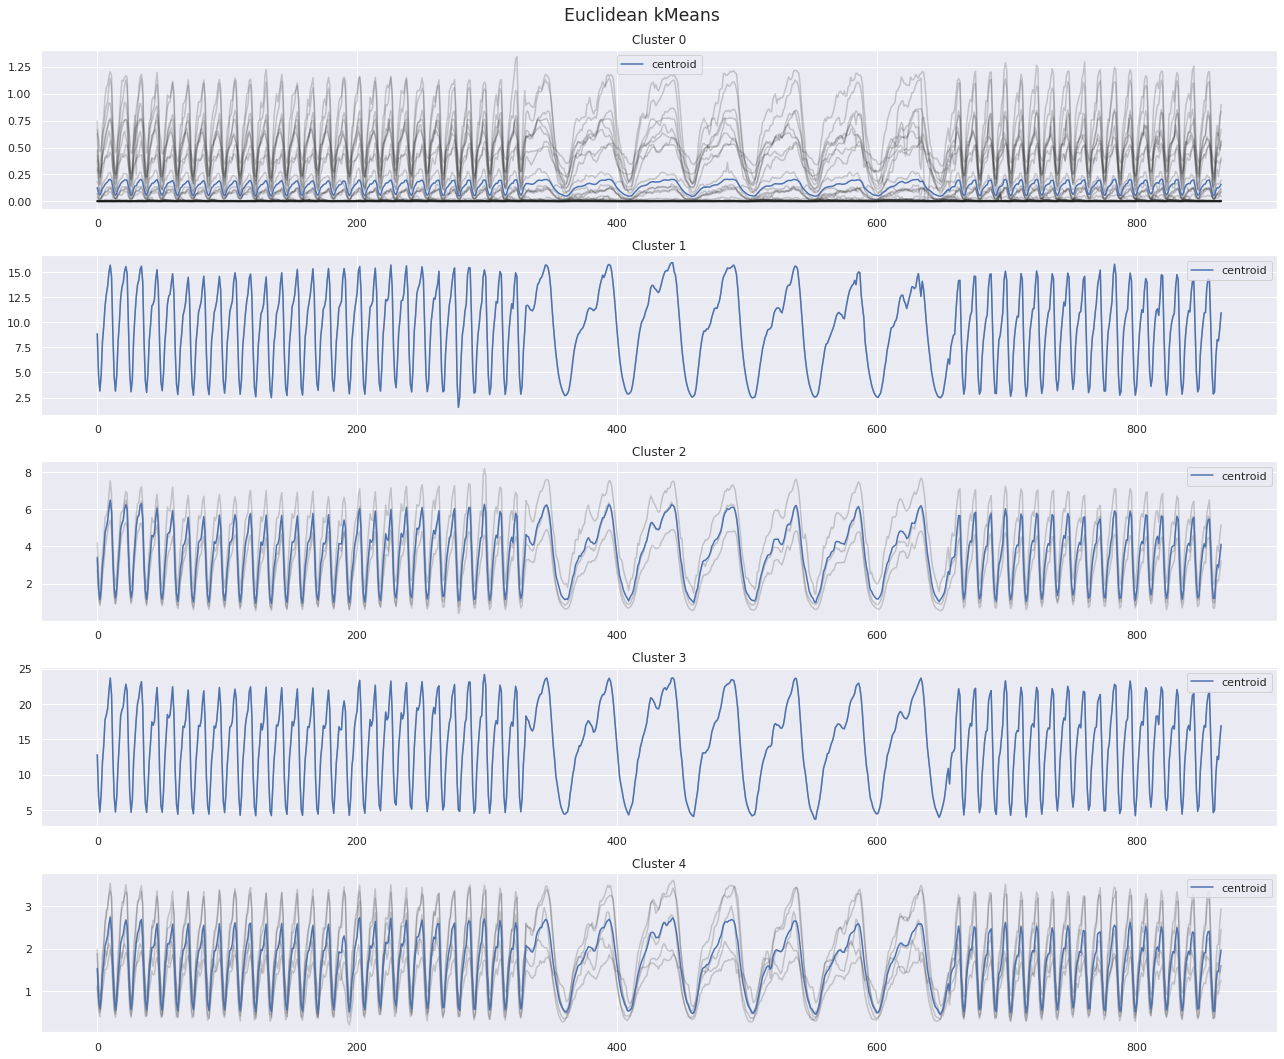

In [102]:
fig = plt.figure(figsize=(18, 15))
for i in range(n_clusters):
    ax = plt.subplot(n_clusters, 1, i + 1)
    for y in x_traspuesta[y_pred == i]:
        ax.plot(y.ravel(), "k-", alpha=.2)
    ax.plot(km.cluster_centers_[i].ravel(), label='centroid')
    ax.set_title(f'Cluster {i}')
    ax.legend()
plt.tight_layout()
fig.suptitle("Euclidean kMeans", fontsize='x-large')
fig.subplots_adjust(top=0.94)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


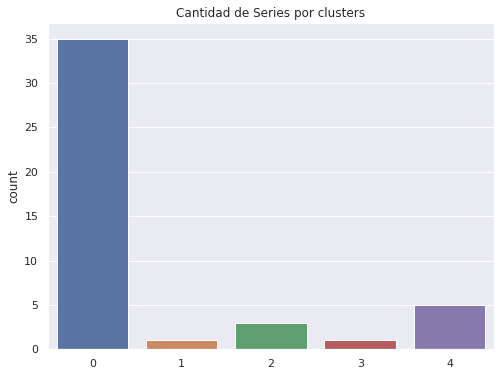

In [103]:
plt.figure(figsize=(8, 6))
sns.countplot(y_pred)
plt.title('Cantidad de Series por clusters')
plt.show()

In [104]:

grupos = {}
for col in zip(df_cluster.columns, y_pred) :
  grupos[col[0]] = col[1]

for key, value in grupos.items():
  df.loc[df.PUNTO_MEDICION == key , 'kmean'] = value

In [105]:
df[['PUNTO_MEDICION','kmean']].groupby('kmean').agg(['count'])

,PUNTO_MEDICION
,count
kmean,
0.0,45185
1.0,1291
2.0,3453
3.0,1291
4.0,6455


Analizaremos los 4 cluster encontrados


CLUSTER 0


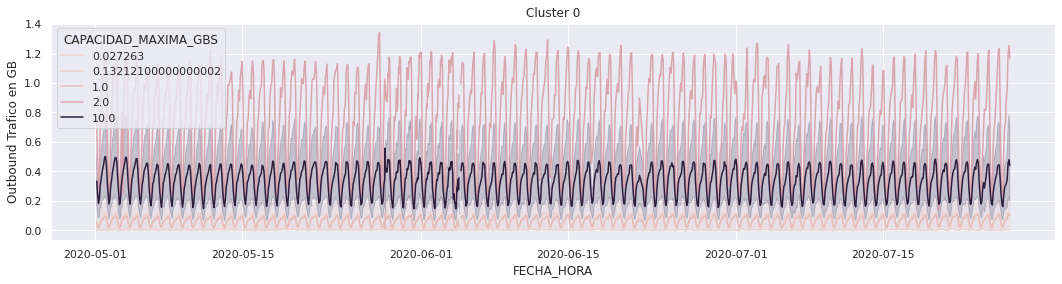

In [106]:
fig = plt.figure(figsize=(18, 4))
auxf = df[df.kmean == 0]
ax = plt.subplot(1, 1, 1)
sns.lineplot(x="FECHA_HORA", y="OUTBOUND_BITS", hue='CAPACIDAD_MAXIMA_GBS',data=auxf, ax=ax)
ax.set_title('Cluster 0')
ax.set_ylabel('Outbound Trafico en GB')
plt.show()

In [107]:
df.loc[(df.kmean==0)][['CAPACIDAD_MAXIMA_GBS','ID_EQUIPO']].groupby('CAPACIDAD_MAXIMA_GBS').agg(['count'])

,ID_EQUIPO
,count
CAPACIDAD_MAXIMA_GBS,
0.027263,1291
0.132121,1291
1.000000,32275
2.000000,1291
10.000000,9037


In [108]:
df.loc[(df.kmean==0)][['PUNTO_MEDICION','ID_EQUIPO']].groupby('PUNTO_MEDICION').agg(['count'])

,ID_EQUIPO
,count
PUNTO_MEDICION,
ABA - Abasto Cliente,1291
BAZ - Carlos Paz,1291
BAZ - Yocsina,1291
Carlos Paz - Cosquin,1291
Carlos Paz - La Falda,1291
EDC - Capitalinas,1291
EDC - Coral State,1291
EDC - ET Oeste,1291


**CLUSTER 1**

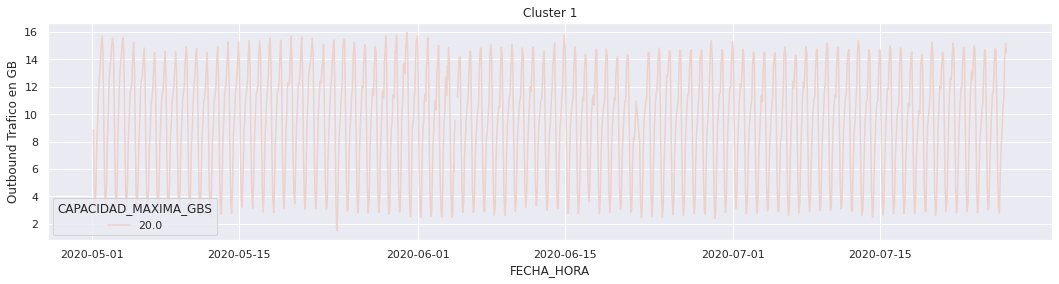

In [109]:
fig = plt.figure(figsize=(18, 4))
auxf = df[df.kmean == 1]
ax = plt.subplot(1, 1, 1)
sns.lineplot(x="FECHA_HORA", y="OUTBOUND_BITS", hue='CAPACIDAD_MAXIMA_GBS',data=auxf, ax=ax)
ax.set_title('Cluster 1')
ax.set_ylabel('Outbound Trafico en GB')
plt.show()

In [110]:
df.loc[(df.kmean==1)][['CAPACIDAD_MAXIMA_GBS','ID_EQUIPO']].groupby('CAPACIDAD_MAXIMA_GBS').agg(['count'])

,ID_EQUIPO
,count
CAPACIDAD_MAXIMA_GBS,
20.0,1291


In [111]:
df.loc[(df.kmean==1)][['PUNTO_MEDICION','ID_EQUIPO']].groupby('PUNTO_MEDICION').agg(['count'])

,ID_EQUIPO
,count
PUNTO_MEDICION,
NOC - 6720HI to BAZ,1291


**CLUSTER 2**


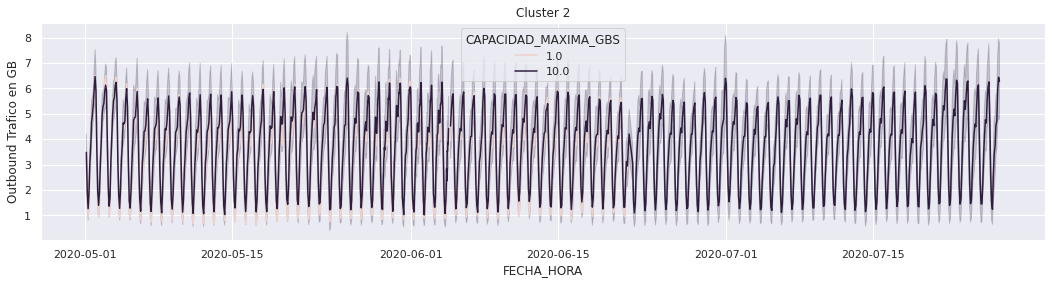

In [112]:
fig = plt.figure(figsize=(18, 4))
auxf = df[df.kmean == 2]
ax = plt.subplot(1, 1, 1)
sns.lineplot(x="FECHA_HORA", y="OUTBOUND_BITS", hue='CAPACIDAD_MAXIMA_GBS',data=auxf, ax=ax)
ax.set_title('Cluster 2')
ax.set_ylabel('Outbound Trafico en GB')
plt.show()

In [113]:
df.loc[(df.kmean==2)][['CAPACIDAD_MAXIMA_GBS','ID_EQUIPO']].groupby('CAPACIDAD_MAXIMA_GBS').agg(['count'])

,ID_EQUIPO
,count
CAPACIDAD_MAXIMA_GBS,
1.0,871
10.0,2582


In [114]:
df.loc[(df.kmean==2)][['PUNTO_MEDICION','ID_EQUIPO']].groupby('PUNTO_MEDICION').agg(['count'])

,ID_EQUIPO
,count
PUNTO_MEDICION,
NOC - S9306 to SS6720HI,871
RDB - JM,1291
Yocsina - Carlos Paz,1291


**CLUSTER 3**

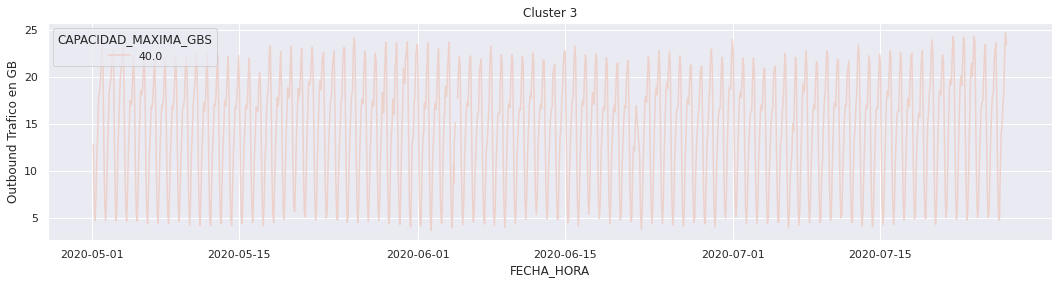

In [115]:
fig = plt.figure(figsize=(18, 4))
auxf = df[df.kmean == 3]
ax = plt.subplot(1, 1, 1)
sns.lineplot(x="FECHA_HORA", y="OUTBOUND_BITS", hue='CAPACIDAD_MAXIMA_GBS',data=auxf, ax=ax)
ax.set_title('Cluster 3')
ax.set_ylabel('Outbound Trafico en GB')
plt.show()

In [116]:
df.loc[(df.kmean==3)][['CAPACIDAD_MAXIMA_GBS','ID_EQUIPO']].groupby('CAPACIDAD_MAXIMA_GBS').agg(['count'])

,ID_EQUIPO
,count
CAPACIDAD_MAXIMA_GBS,
40.0,1291


In [117]:
df.loc[(df.kmean==3)][['PUNTO_MEDICION','ID_EQUIPO']].groupby('PUNTO_MEDICION').agg(['count'])

,ID_EQUIPO
,count
PUNTO_MEDICION,
NOC - 6720HI to EDC,1291


**CLUSTER 4**

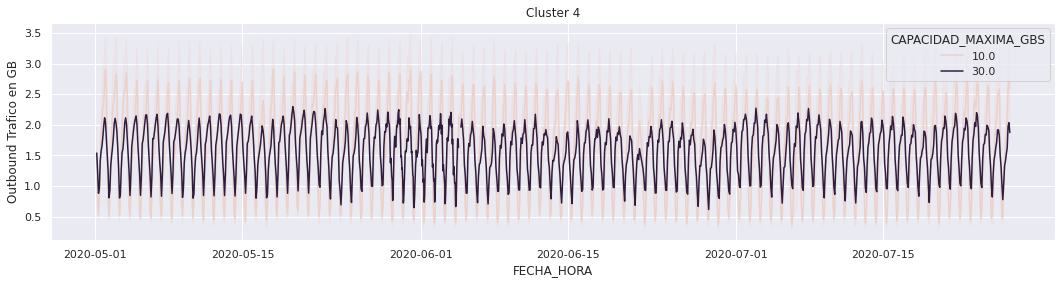

In [118]:
fig = plt.figure(figsize=(18, 4))
auxf = df[df.kmean == 4]
ax = plt.subplot(1, 1, 1)
sns.lineplot(x="FECHA_HORA", y="OUTBOUND_BITS", hue='CAPACIDAD_MAXIMA_GBS',data=auxf, ax=ax)
ax.set_title('Cluster 4')
ax.set_ylabel('Outbound Trafico en GB')
plt.show()

In [119]:
df.loc[(df.kmean==4)][['CAPACIDAD_MAXIMA_GBS','ID_EQUIPO']].groupby('CAPACIDAD_MAXIMA_GBS').agg(['count'])

,ID_EQUIPO
,count
CAPACIDAD_MAXIMA_GBS,
10.0,5164
30.0,1291


In [120]:
df.loc[(df.kmean==4)][['PUNTO_MEDICION','ID_EQUIPO']].groupby('PUNTO_MEDICION').agg(['count'])

,ID_EQUIPO
,count
PUNTO_MEDICION,
JM - Totoral Vieja,1291
NOC - 6720HI to N20-1,1291
RDB - GZU,1291
RDB - RIO,1291
SF - Freyre,1291
